In [1]:
%matplotlib inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from sotodlib import core
from sotodlib.core.metadata import ManifestDb, load_metadata
import sotodlib.io.load_book as lb

from optical_loading import pwv_interp, get_fpa_temps, UXM_dict, add_iv_info
import map_utils as mu

import dill as pk
import os
import glob
import h5py

%load_ext autoreload
%autoreload 2

/so/home/jorlo/venvs/sotodlib/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#lat_baseline = core.AxisManager.load("v3r7_baseline_pwv_el_sweep_LAT.h5")
#lat_goal = core.AxisManager.load("v3r7_goal_pwv_el_sweep_LAT.h5")
#edx = np.where( np.isclose(lat_goal.elevations,50) )[0][0]

In [3]:
with open("opt_load_det.pk", "rb") as f:
    optical_loading_detectors = pk.load(f)
det_match_path = "/so/home/mrandall/Analysis/Detmatching/Matched_Dark_Cal/lat/"
detmatches = glob.glob(det_match_path + "*.h5")

In [4]:
## context for loading data
ctx = core.Context('/so/metadata/lat/contexts/smurf_detsets.yaml')


In [5]:
ufm = "uv39"

if "uv" in ufm:
    ufm_type="UHF"
    ufm_1 = "UHF_1"
    ufm_2 = "UHF_2"
    low_freq = "220"
    high_freq = "280"

elif "mv" in ufm:
    ufm_type="MF"
    ufm_1 = "MF_1"
    ufm_2 = "MF_2"
    low_freq = "090"
    high_freq = "150"

else:
    ufm_type="LF"
    ufm_1 = "LF_1"
    ufm_2 = "LF_2"
    low_freq = "030"
    high_freq = "040"

start = dt.datetime(2025,4,17, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,5,5, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='oper' and subtype=='iv'"
    " and stream_ids_list == 'ufm_{}'".format(ufm)
)


In [6]:
iv_fname = "ivs/all_ivs_{}.h5".format(ufm)
obs_fname = "ivs/obs_info_{}.h5".format(ufm)
if os.path.exists(iv_fname) and os.path.exists(obs_fname):
    all_iv_data = core.AxisManager.load(iv_fname)
    obs_info = core.AxisManager.load(obs_fname)

else:
    ## from above, I know obs_list has only one stream_id in it

    singles = []
    obs_start = 0
    obs_end = len(obs_list)
    for i in range(obs_start,obs_end):
        obs = obs_list[i]
        meta = ctx.get_meta(obs)
        try:
            add_iv_info(meta, ctx)
            singles.append(meta)
        except FileNotFoundError:
            print(meta.obs_info.obs_id)
    x = [m.dets.count for m in singles]
    flags = np.array([i for i, l in enumerate(x) if l == min(x)])
    x = np.array(x)[flags]
    singles = np.array(singles)[flags]
    obs_list = np.array(obs_list)[flags] 
    assert min(x) == max(x), "Need to add some additional checks if channel counts are changing"

    all_iv_data = core.AxisManager(
        singles[0].dets,
        core.IndexAxis('obs', len(singles)),
    )

    pwv = pwv_interp()

    obs_info = core.AxisManager(all_iv_data.obs)
    for f in singles[0].obs_info._fields.keys():
        if f == 'end_time' or f =='detector_flavor':
            continue
        else:
            if isinstance(singles[0].obs_info[f], str): #If the field is a string
                #We have to declare the type to be bytes
                #h5 files can't handle strings well
                #h5 will auto encode strings into bytes though
                obs_info.wrap_new(f, ('obs',), dtype=f'<U{len(singles[0].obs_info[f])}')
            else:    
                obs_info.wrap_new( f, ('obs',), dtype=type(singles[0].obs_info[f]))

    #Add pwv
    obs_info.wrap_new("pwv", ('obs',), dtype=float)
    obs_info.wrap_new("ufm_temp", ('obs',), dtype=float)

    fpa_temps = get_fpa_temps(obs_list[obs_start:obs_end])

    for m, meta in enumerate(singles):
        for f in singles[0].obs_info._fields.keys():
            if f=='end_time' or f=='detector_flavor':
                continue
            obs_info[f][m] = meta.obs_info[f]
        obs_info["pwv"][m] = pwv((obs_info["start_time"][m] + obs_info["stop_time"][m])/2)
        obs_info["ufm_temp"][m] = fpa_temps[m]

    all_iv_data.wrap('obs_info', obs_info)
    all_iv_data.wrap('det_info', singles[0].det_info)
    # don't have a focal plane yet
    #all_iv_data.wrap('focal_plane', singles[0].focal_plane)

    iv_data = core.AxisManager( all_iv_data.dets, all_iv_data.obs)
    for f in singles[0].iv._fields.keys():
        iv_data.wrap_new(f, ('dets','obs'), dtype=singles[0].iv[f].dtype)
        iv_data[f] *= np.nan

    for m, meta in enumerate(singles):
        for f in singles[0].iv._fields.keys():
            iv_data[f][:,m] = meta.iv[f][:]
    all_iv_data.wrap('iv', iv_data)

    #all_iv_data.obs_info.move("detector_flavor", new_name=None)

    all_iv_data.save(iv_fname, overwrite=True)
    obs_info.save(obs_fname, overwrite=True)

In [7]:
all_iv_data.iv.p_sat.shape

(1698, 96)

In [8]:
lopts_low = []
lopts_high = []
for i, psat in enumerate(all_iv_data.iv.p_sat):
    if all_iv_data["iv"]["bgmap"][...,0][i] in [0,1,4,5,8,9]:
        freq = "low"
    elif all_iv_data["iv"]["bgmap"][...,0][i] in [2,3,6,7,10,11]:
        freq = "high"
    else:
        continue
    n = UXM_dict[freq][ufm]["n"]
    lopt = UXM_dict[freq][ufm]["psat_dark"]- psat + UXM_dict[freq][ufm]["kappa"]*(0.1**n - obs_info.ufm_temp**n)
    
    if all([np.isnan(item) for item in lopt]):
        continue
    
    if all_iv_data["iv"]["bgmap"][...,0][i] in [0,1,4,5,8,9]:
        lopts_low.append(lopt)
    elif all_iv_data["iv"]["bgmap"][...,0][i] in [2,3,6,7,10,11]:
        lopts_high.append(lopt)
lopts_low = np.array(lopts_low, dtype=float)
lopts_high = np.array(lopts_high, dtype=float)

flags_low = [] #Flag out obs that are entirely nan
               #This is surprisingly tricky using np funcs
for i in range(lopts_low.shape[1]):
    if not np.isnan(lopts_low.T[i]).all():
        flags_low.append(i)
flags_low = np.array(flags_low)

flags_high = []
for i in range(lopts_high.shape[1]):
    if not np.isnan(lopts_high.T[i]).all():
        flags_high.append(i)
flags_high = np.array(flags_high)

lopts_low = lopts_low[...,flags_low]
lopts_high = lopts_high[...,flags_high]

In [9]:
lopts_low.shape

(794, 90)

In [10]:
idx_dict = {"030": 0, "040":1, "090": 2, "150": 3, "220": 4, "280": 5}

In [11]:


saturated = np.zeros(len(all_iv_data.iv.p_sat.T))
for i, obs in enumerate(all_iv_data.iv.p_sat.T):
    saturated[i] = len(np.where((obs <= 0.1))[0]) + sum(np.isnan(x) for x in obs)
    



In [19]:
all_iv_data.iv.p_sat.T[0]

array([17.02646033, 10.96236362, 14.05227172, ..., 16.91153448,
       10.70707248,  9.73362209], shape=(1698,))

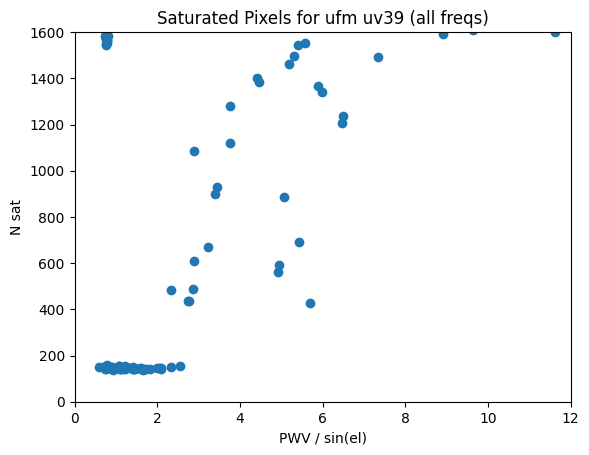

In [12]:
plt.scatter(obs_info.pwv/np.sin(obs_info.el_center* np.pi / 180.), saturated)
plt.title("Saturated Pixels for ufm {} (all freqs)".format(ufm))

plt.xlabel("PWV / sin(el)")
plt.ylabel("N sat")

plt.xlim(0, 12)
plt.ylim(0, 1600)

plt.savefig("./plts/sats/sat_{}.pdf".format(ufm), dpi=600)
plt.savefig("./plts/sats/sat_{}.png".format(ufm), dpi=600)

(0.0, 1600.0)

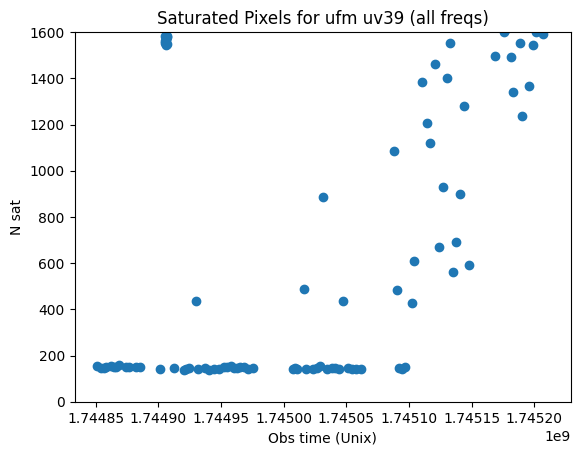

In [13]:
plt.scatter(obs_info.timestamp, saturated)
plt.title("Saturated Pixels for ufm {} (all freqs)".format(ufm))

plt.xlabel("Obs time (Unix)")
plt.ylabel("N sat")

#plt.xlim(0, 12)
plt.ylim(0, 1600)



In [14]:
obs_info.pwv

array([0.83014717, 0.77342865, 0.71427458, 0.63811792, 0.60487993,
       0.61056002, 0.61980918, 0.60100578, 0.5928    , 0.57537487,
       0.5676    , 0.61041022, 0.63635298, 0.6936    , 0.67154462,
       0.68602395, 0.66533815, 0.6684    , 0.67045342, 0.67272395,
       0.6768    , 0.65011643, 0.66236735, 0.66318145, 0.64684985,
       0.70490608, 0.82650477, 0.92395385, 0.94877633, 0.94126102,
       0.79017407, 0.7272    , 0.70595123, 0.72145577, 0.70490748,
       0.67726827, 0.68252737, 0.68706065, 0.6768    , 0.69203862,
       0.702     , 0.6936    , 0.66      , 0.66      , 0.90796703,
       0.91932135, 0.9708    , 0.97987189, 0.93903185, 0.83421702,
       0.86536417, 0.87212722, 0.88083595, 0.86868047, 0.85578225,
       0.9372    , 0.93042965, 0.9456    , 0.996     , 1.0296    ,
       1.05690073, 1.08608898, 0.98940169, 0.9876    , 1.01629785,
       1.206     , 1.53651238, 1.94542042, 1.90171942, 2.23108269,
       2.21019329, 2.41058068, 2.59840077, 2.79496312, 2.63487

In [16]:
obs_info.el_center

array([50.    , 60.    , 20.    , 70.    , 30.    , 50.    , 30.    ,
       50.    , 30.    , 40.    , 70.    , 60.    , 60.    , 59.9999,
       59.9999, 59.9999, 59.9999, 59.9999, 59.9999, 59.9999, 59.9999,
       59.9999, 59.9999, 59.9998, 59.9998, 60.    , 30.    , 35.    ,
       41.3   , 20.    , 41.2   , 50.    , 50.    , 40.    , 30.    ,
       60.    , 50.    , 40.    , 30.    , 40.    , 30.    , 70.    ,
       60.    , 40.    , 30.    , 35.    , 41.3   , 20.    , 41.2   ,
       50.    , 25.    , 20.    , 10.    , 30.    , 60.    , 50.    ,
       40.    , 20.    , 30.    , 70.    , 60.    , 40.    , 20.    ,
       25.    , 40.    , 35.    , 41.    , 20.    , 41.    , 30.    ,
       20.    , 40.    , 30.    , 60.    , 50.    , 40.    , 30.    ,
       40.    , 30.    , 70.    , 60.    , 40.    , 40.    , 20.    ,
       25.    , 30.    , 35.    , 41.    , 20.    , 41.    , 50.    ,
       60.    , 20.    , 10.    , 30.    , 30.    ])

## Fit data

In [1568]:
fname = "lopt_fits.pk"
if os.path.exists(fname):
    with open(fname, "rb") as f:
        lopt_fit_dict = pk.load(f)
else:
    lopt_fit_dict = {}
    
indv_lopts_fname = "lopt_indv.pk"
if os.path.exists(indv_lopts_fname):
    with open(indv_lopts_fname, "rb") as f:
        lopt_indv_dict = pk.load(f)
else:
    lopt_indv_dict = {}
    
sat_fname = "lopt_sat.pk"
if os.path.exists(sat_fname):
    with open(sat_fname, "rb") as f:
        sat_dict = pk.load(f)
else:
    sat_dict = {}
    
    
from scipy.optimize import curve_fit

In [1569]:
saturated_low = np.zeros(len(all_iv_data.iv.p_sat.T))
saturated_high = np.zeros(len(all_iv_data.iv.p_sat.T))
obs_ids = []
for i, obs in enumerate(all_iv_data.iv.p_sat.T):
    obs_ids.append(all_iv_data.obs_info.obs_id[i])
    other_sat = int(len([j for j in range(len(all_iv_data["iv"]["bgmap"][...,i])) if all_iv_data["iv"]["bgmap"][j,i] not in np.arange(0,12,1)])/2)
    low_flags = [j for j in range(len(all_iv_data["iv"]["bgmap"][...,i])) if all_iv_data["iv"]["bgmap"][j,i] in [0,1,4,5,8,9]]
    saturated_low[i] = len(np.where((obs[low_flags] <= 0.1))[0]) + sum(np.isnan(x) for x in obs[low_flags]) + other_sat
    high_flags = [j for j in range(len(all_iv_data["iv"]["bgmap"][...,i])) if all_iv_data["iv"]["bgmap"][j,i] in [2,3,6,7,10,11]]
    saturated_high[i] = len(np.where((obs[high_flags] <= 0.1))[0]) + sum(np.isnan(x) for x in obs[high_flags]) + other_sat

sat_dict[ufm] = {"pwv_sinel":obs_info.pwv/np.sin(obs_info.el_center* np.pi / 180.), 
                 "obs_id":obs_ids, "low":saturated_low, "high":saturated_high}
with open(sat_fname, "wb") as f:
    pk.dump(sat_dict, f)

In [1570]:
def func(x, L0, Lwet):
    return L0 + Lwet * x

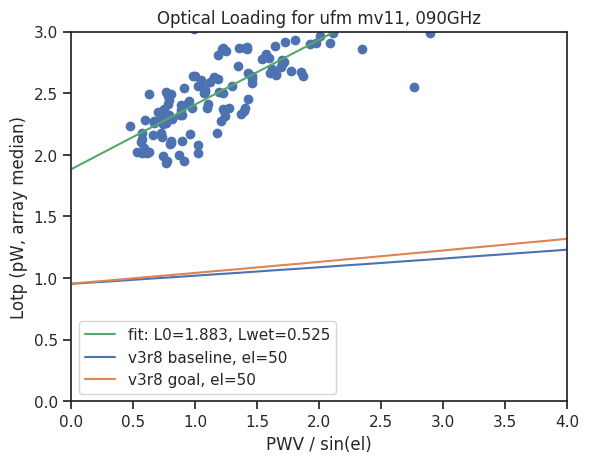

In [1571]:
xdata, ydata = obs_info.pwv[flags_low]/np.sin(obs_info.el_center[flags_low]* np.pi / 180.), np.nanmedian(lopts_low, axis = 0)

pwvcut = np.where((xdata <= 3.0) & (0<ydata) & (ydata<100))

xdata = xdata[pwvcut]
ydata = ydata[pwvcut]

lopt_indv_dict[ufm] = {low_freq:{"pwv_sinel":xdata, "lopt":ydata}}

popt, pcov = curve_fit(func, xdata, ydata)

lopt_fit_dict[ufm] = {low_freq:{}, high_freq:{}}
lopt_fit_dict[ufm][low_freq]["popt"] = popt
lopt_fit_dict[ufm][low_freq]["pcov"] = pcov



plt.plot(optical_loading_detectors["pwv_sin_el"], func(optical_loading_detectors["pwv_sin_el"], *popt), 'g',label='fit: L0=%5.3f, Lwet=%5.3f' % tuple(popt))
plt.scatter(xdata, ydata)

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"][ufm_type][ufm_1], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"][ufm_type][ufm_1], label="v3r8 goal, el=50")

plt.xlabel("PWV / sin(el)")
plt.ylabel("Lotp (pW, array median)")

plt.title("Optical Loading for ufm {}, {}GHz".format(ufm, low_freq))

plt.xlim(0,4)

if low_freq == "090":
    plt.ylim(0,3)
elif low_freq == "220":
    plt.ylim(0, 25)

plt.legend()
plt.savefig("./plts/lopts/lopt_{}_{}.pdf".format(ufm, low_freq), dpi=600)
plt.savefig("./plts/lopts/lopt_{}_{}.png".format(ufm, low_freq), dpi=600)

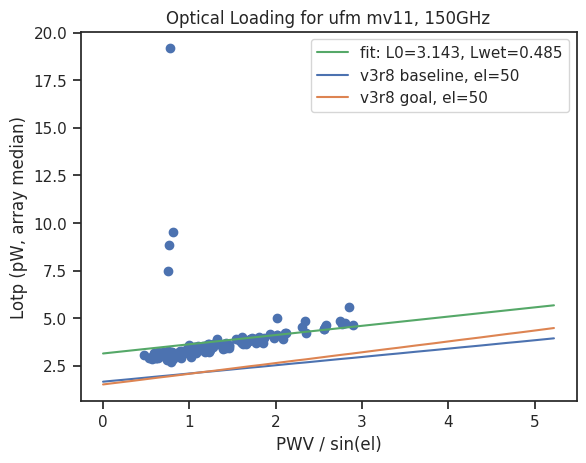

In [1572]:
xdata, ydata = obs_info.pwv[flags_high]/np.sin(obs_info.el_center[flags_high]* np.pi / 180.), np.nanmedian(lopts_high, axis = 0)

pwvcut = np.where((xdata <= 3.0) & (0<ydata) & (ydata<100))

xdata = xdata[pwvcut]
ydata = ydata[pwvcut]

lopt_indv_dict[ufm][high_freq] = {"pwv_sinel":xdata, "lopt":ydata}

popt, pcov = curve_fit(func, xdata, ydata)

lopt_fit_dict[ufm][high_freq]["popt"] = popt
lopt_fit_dict[ufm][high_freq]["pcov"] = pcov

plt.plot(optical_loading_detectors["pwv_sin_el"], func(optical_loading_detectors["pwv_sin_el"], *popt), 'g',label='fit: L0=%5.3f, Lwet=%5.3f' % tuple(popt))
plt.scatter(xdata, ydata)

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"][ufm_type][ufm_2], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"][ufm_type][ufm_2], label="v3r8 goal, el=50")

plt.xlabel("PWV / sin(el)")
plt.ylabel("Lotp (pW, array median)")

plt.title("Optical Loading for ufm {}, {}GHz".format(ufm, high_freq))

plt.xlim(0,4)
if low_freq == "090":
    plt.ylim(0,4)
elif low_freq == "220":
    plt.ylim(0, 30)
plt.legend()

plt.savefig("./plts/lopts/lopt_{}_{}.pdf".format(ufm, high_freq), dpi=600)
plt.savefig("./plts/lopts/lopt_{}_{}.png".format(ufm, high_freq), dpi=600)

In [1573]:
with open(fname, "wb") as f:
    pk.dump(lopt_fit_dict, f)
with open(indv_lopts_fname, "wb") as f:
    pk.dump(lopt_indv_dict, f)

# All Lopts

In [1020]:
fname = "lopt_fits.pk"

with open(fname, "rb") as f:
    lopt_dict = pk.load(f)
    
import seaborn as sns
import pandas as pd

def func(x, L0, Lwet):
    return L0 + Lwet * x

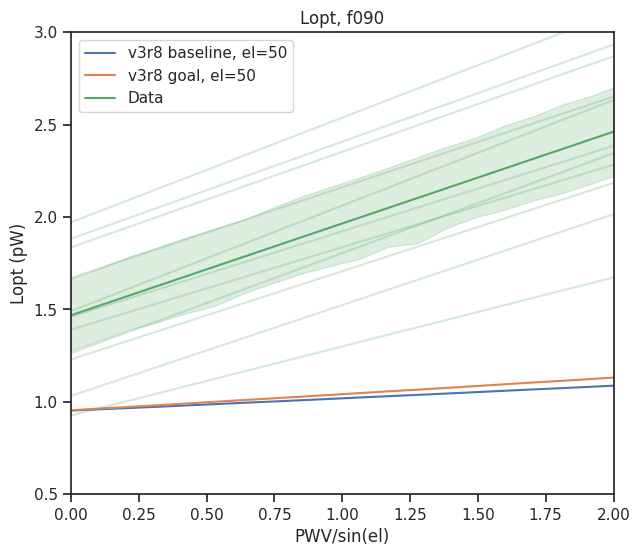

In [1021]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"]["MF"]["MF_1"], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"]["MF"]["MF_1"], label="v3r8 goal, el=50")

xs = []
ys = []
for key in lopt_dict.keys():
    if "mv" in key:
        popt = lopt_dict[key]["090"]["popt"]
        y=func(optical_loading_detectors["pwv_sin_el"], *popt) 
        for i in range(len(optical_loading_detectors["pwv_sin_el"])):
            xs.append(optical_loading_detectors["pwv_sin_el"][i])
            ys.append(y[i])
        plt.plot(optical_loading_detectors["pwv_sin_el"], y, 'g', alpha = 0.25)
        
df = pd.DataFrame({"PWV/sin(el)":xs, "Lopt (pW)":ys})        
sns.lineplot(x="PWV/sin(el)", y="Lopt (pW)",
            data=df, label="Data") 
plt.legend()

plt.xlim(0,2)
plt.ylim(0.5,3)
plt.title("Lopt, f090")
plt.savefig("./plts/lopts/lopts_f090.png", dpi=600)
plt.savefig("./plts/lopts/lopts_f090.pdf", dpi=600)

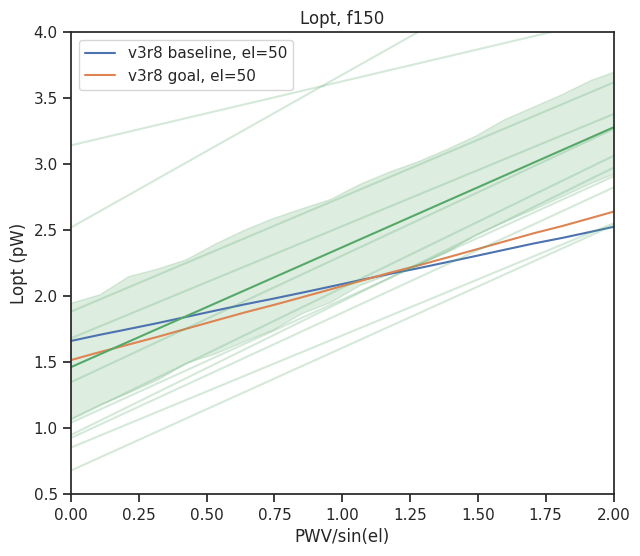

In [1022]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"]["MF"]["MF_2"], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"]["MF"]["MF_2"], label="v3r8 goal, el=50")

xs = []
ys = []
for key in lopt_dict.keys():
    if "mv" in key:
        popt = lopt_dict[key]["150"]["popt"]
        y=func(optical_loading_detectors["pwv_sin_el"], *popt) 
        for i in range(len(optical_loading_detectors["pwv_sin_el"])):
            xs.append(optical_loading_detectors["pwv_sin_el"][i])
            ys.append(y[i])
        plt.plot(optical_loading_detectors["pwv_sin_el"], y, 'g', alpha = 0.25)
        
df = pd.DataFrame({"PWV/sin(el)":xs, "Lopt (pW)":ys})        
sns.lineplot(x="PWV/sin(el)", y="Lopt (pW)",
            data=df) 
plt.legend()

plt.xlim(0,2)
plt.ylim(0.5,4)

plt.title("Lopt, f150")

plt.savefig("./plts/lopts/lopts_f150.png", dpi=600)
plt.savefig("./plts/lopts/lopts_f150.pdf", dpi=600)

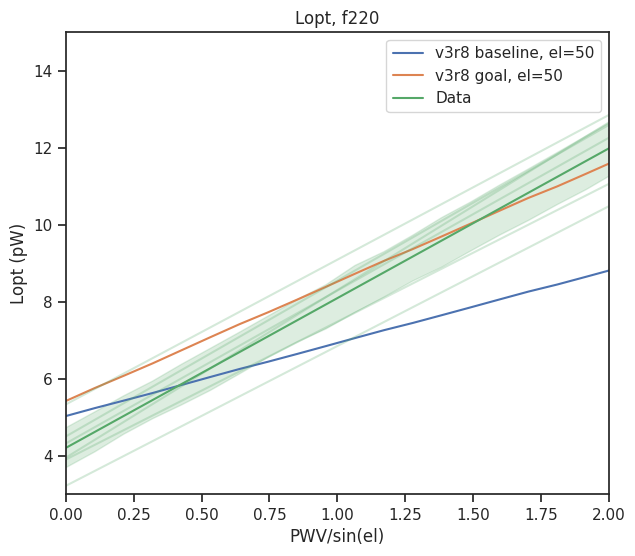

In [1023]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"]["UHF"]["UHF_1"], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"]["UHF"]["UHF_1"], label="v3r8 goal, el=50")

xs = []
ys = []
for key in lopt_dict.keys():
    if "uv" in key:
        popt = lopt_dict[key]["220"]["popt"]
        y=func(optical_loading_detectors["pwv_sin_el"], *popt) 
        for i in range(len(optical_loading_detectors["pwv_sin_el"])):
            xs.append(optical_loading_detectors["pwv_sin_el"][i])
            ys.append(y[i])
        plt.plot(optical_loading_detectors["pwv_sin_el"], y, 'g', alpha = 0.25)
        
df = pd.DataFrame({"PWV/sin(el)":xs, "Lopt (pW)":ys})        
sns.lineplot(x="PWV/sin(el)", y="Lopt (pW)",
            data=df, label="Data") 
plt.legend()

plt.xlim(0,2)
plt.ylim(3,15)

plt.title("Lopt, f220")

plt.savefig("./plts/lopts/lopts_f220.png", dpi=600)
plt.savefig("./plts/lopts/lopts_f220.pdf", dpi=600)

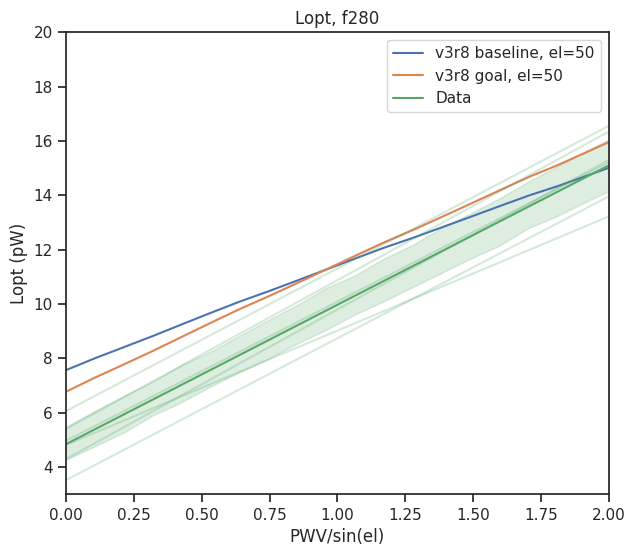

In [1024]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["baseline"]["UHF"]["UHF_2"], label="v3r8 baseline, el=50")
plt.plot(optical_loading_detectors["pwv_sin_el"], 1e12*optical_loading_detectors["goal"]["UHF"]["UHF_2"], label="v3r8 goal, el=50")

xs = []
ys = []
for key in lopt_dict.keys():
    if "uv" in key:
        popt = lopt_dict[key]["280"]["popt"]
        y=func(optical_loading_detectors["pwv_sin_el"], *popt) 
        for i in range(len(optical_loading_detectors["pwv_sin_el"])):
            xs.append(optical_loading_detectors["pwv_sin_el"][i])
            ys.append(y[i])
        plt.plot(optical_loading_detectors["pwv_sin_el"], y, 'g', alpha = 0.25)
        
df = pd.DataFrame({"PWV/sin(el)":xs, "Lopt (pW)":ys})        
sns.lineplot(x="PWV/sin(el)", y="Lopt (pW)",
            data=df, label="Data") 
plt.legend()

plt.xlim(0,2)
plt.ylim(3,20)

plt.title("Lopt, f280")

plt.savefig("./plts/lopts/lopts_f280.png", dpi=600)
plt.savefig("./plts/lopts/lopts_f280.pdf", dpi=600)

# Yields from Lopts

In [1490]:
sat_fname = "lopt_sat.pk"
with open(sat_fname, "rb") as f:
    sat_dict = pk.load(f)

In [1491]:
obs_ids = []
for key in sat_dict.keys():
    if "mv" in key:
        obs_ids.append(sat_dict[key]["obs_id"])

In [1493]:
times = mu.get_matching_obs(obs_ids)

In [1494]:
sats_low = np.zeros(times.shape[1])
sats_high = np.zeros(times.shape[1])
pwvs = 0
i = 0

for key in sat_dict.keys():
    if "mv" in key:
        sats_low += np.array(sat_dict[key]["low"])[times[i]]
        sats_high += np.array(sat_dict[key]["high"])[times[i]]
        pwvs = np.array(sat_dict[key]["pwv_sinel"])[times[i]]
        
        i += 1

pwvs_mf = np.concatenate([pwvs, pwvs])       
labels_mf = np.concatenate([["f090"]*len(sats_low), ["f150"]*len(sats_high)])
yields_mf = np.concatenate([1- (sats_low) / (11*860), 1- (sats_high) / (11*860)])
df_mf = pd.DataFrame({"pwvs":pwvs_mf, "labels":labels_mf, "yields":yields_mf})

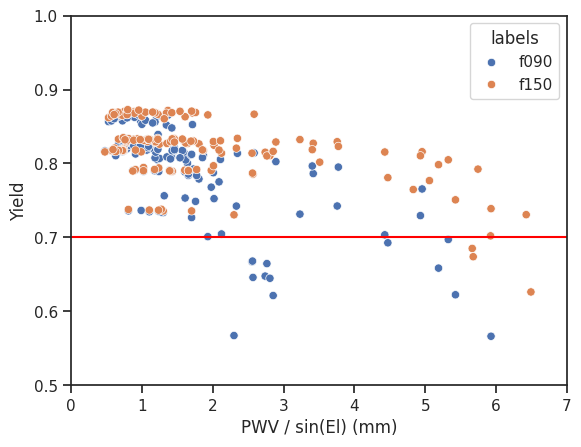

In [1495]:
sns.scatterplot(
    data=df_mf,
    x="pwvs", y="yields", hue="labels",
)

xmax=7
plt.xlim(0,xmax)
plt.ylim(0.5, 1)

plt.xlabel("PWV / sin(El) (mm)")
plt.ylabel("Yield")

plt.hlines(0.7, 0, xmax, color="red")

plt.savefig("./plts/yield_pwv_mf.png", dpi=600)
plt.savefig("./plts/yield_pwv_mf.pdf", dpi=600)

In [1528]:
obs_ids = []
for key in sat_dict.keys():
    if "uv" in key:
        obs_ids.append(sat_dict[key]["obs_id"])
times = mu.get_matching_obs(obs_ids)

sats_low = np.zeros(times.shape[1])
sats_high = np.zeros(times.shape[1])
pwvs = 0
i = 0

for key in sat_dict.keys():
    if "uv" in key:
        sats_low += np.array(sat_dict[key]["low"])[times[i]]
        sats_high += np.array(sat_dict[key]["high"])[times[i]]
        pwvs = np.array(sat_dict[key]["pwv_sinel"])[times[i]]
        
        i += 1

pwvs_uhf = np.concatenate([pwvs, pwvs])       
labels_uhf = np.concatenate([["f220"]*len(sats_low), ["f280"]*len(sats_high)])
yields_uhf = np.concatenate([1- (sats_low) / (6*860), 1- (sats_high) / (6*860)])
df_uhf = pd.DataFrame({"pwvs":pwvs_uhf, "labels":labels_uhf, "yields":yields_uhf})

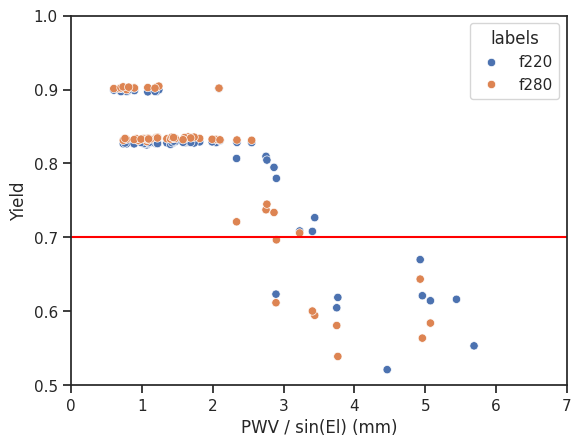

In [1529]:
sns.scatterplot(
    data=df_uhf,
    x="pwvs", y="yields", hue="labels",
)

xmax = 7.0
plt.xlim(0,xmax)
plt.ylim(0.5, 1)

plt.hlines(0.7, 0, xmax, color="red")

plt.xlabel("PWV / sin(El) (mm)")
plt.ylabel("Yield")

plt.savefig("./plts/yield_pwv_uhf.png", dpi=600)
plt.savefig("./plts/yield_pwv_uhf.pdf", dpi=600)

In [1530]:
pwvs_comb = np.concatenate([pwvs_mf, pwvs_uhf])
labels_comb =np.concatenate([labels_mf, labels_uhf])
yields_comb = np.concatenate([yields_mf, yields_uhf])
df_comb = pd.DataFrame({"pwvs":pwvs_comb, "yields":yields_comb, "labels":labels_comb})

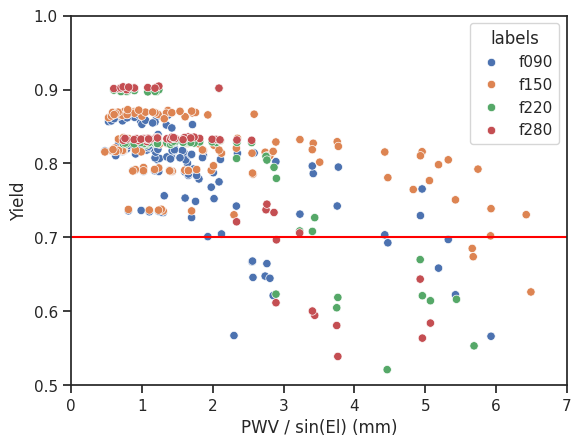

In [1531]:
sns.scatterplot(
    data=df_comb,
    x="pwvs", y="yields", hue="labels",
)

xmax = 7.0
plt.xlim(0,xmax)
plt.ylim(0.5, 1)

plt.hlines(0.7, 0, xmax, color="red")

plt.xlabel("PWV / sin(El) (mm)")
plt.ylabel("Yield")

plt.savefig("./plts/yield_pwv.png", dpi=600)
plt.savefig("./plts/yield_pwv.pdf", dpi=600)

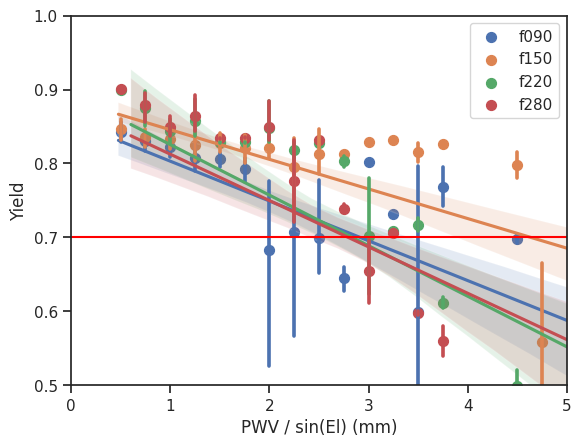

In [1546]:
order = 1
sns.regplot(data=df_comb.where(df_comb.labels=="f090"), x="pwvs", y="yields", x_bins=np.arange(0, 5, 0.250), order=order, label="f090")
sns.regplot(data=df_comb.where(df_comb.labels=="f150"), x="pwvs", y="yields", x_bins=np.arange(0, 5, 0.250), order=order, label="f150")
sns.regplot(data=df_comb.where(df_comb.labels=="f220"), x="pwvs", y="yields", x_bins=np.arange(0, 5, 0.250), order=order, label="f220")
sns.regplot(data=df_comb.where(df_comb.labels=="f280"), x="pwvs", y="yields", x_bins=np.arange(0, 5, 0.250), order=order, label="f280")

plt.xlim(0,5)
plt.ylim(0.5, 1)

plt.hlines(0.7, 0, xmax, color="red")

plt.xlabel("PWV / sin(El) (mm)")
plt.ylabel("Yield")

plt.legend()
plt.savefig("./plts/yield_pwv.png", dpi=600)
plt.savefig("./plts/yield_pwv.pdf", dpi=600)